## N-Asset Efficient Frontier

In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import edhec_risk_kit as erk
from scipy.optimize import minimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
ind = erk.get_ind_returns()
er = erk.annualized_rets(ind["1996":"2000"],12)
cov = ind["1996":"2000"].cov()

As we have already mentioned the key to obtain the efficient frontier for N assets is using a quadratic optimizer. Fortunately, scipy.optimize already has one, so we can use it :). As I think that the function we've developed is interesting, I will leave it here apart from adding it to the module:

In [75]:
def minimize_vol(target_return,er,cov):
    """
    Given some constraints and an initial guess, it returns the weights
    that produce the minimum volatility for a target return.
    """
    
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    
    #We need some constraints
    
    return_is_target = {'type': 'eq', #constraint that says our function below has to equal zero
                        'args':(er,), #makes sure that additional arguments (that are constant) are added to the function
                        'fun' : lambda weights, er: target_return - erk.portfolio_return(weights,er) #function that has to meet the constraint
    }

    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
  
    
    results = minimize(erk.portfolio_vol,init_guess,args=(cov,), method = "SLSQP", options={"disp": False},
                      constraints=(return_is_target_2, weights_sum_to_1),
                      bounds=bounds)
    
    # In minimize, we have a function called erk.portfolio_vol that depends on two arguments: covariance matrix
    # and weights. However, we only want the minimization of the function by changing the weights, as the covariance
    # matrix is a constant (for this reason, we use args=(cov,) ). Apart from this, the function minimize also
    # requires constraints and bound, and the method we will use to optimize.
    
    
    return results.x #solution array, have a look at documentation
    
    

What we can do now is see if it works for the 2-asset case, as we already have the results.

In [80]:
l = ["Games","Fin"]

In [77]:
weights_min = erk.minimize_vol(0.15,er[l],cov.loc[l,l]) #as we can see in 2_2, minimum volatility is around the return 0.15
erk.portfolio_vol(weights_min,cov.loc[l,l])

0.056163669406706564

If we go back to the previous notebook, we can see that for a return of 0.15, that is actually the minimum volatility. Now that we have a function that gives the weights for a certain return, we should create another function that returns the weights for all the possible returns, which are inside the interval $[min(returns), max(returns)]$. Again, I will leave the function here because I find it particularly interesting:

In [84]:
def optimal_weights(n_points,er,cov):
    """ 
    Returns a list of weights that minimize the volatility associated to n equally spaced points
    in the interval [min(er),max(er)], where er is the expected return. Cov is the covariance 
    matrix.
    """
    target_returns = np.linspace(er.min(),er.max(),n_points)
    weights = [erk.minimize_vol(target_ret,er,cov) for target_ret in target_returns]
    
    return weights

Finally, we can create another function that would plot for us the efficient frontier. In this case, I added "plot" as a parameter that must be set to True in order to plot the efficient frontier. Otherwise, it will only return a DataFrame with the minimized volatility for each return and the associated weights.

In [154]:
def ef_multi(n_points,er,cov,plot=False):
    
    """
    Returns a Dataframe a multi-asset efficient frontier, i.e returns and associated weights and minimized
    volatility. If plot==True, it plots the efficient frontier.
    """
    
    weights = erk.optimal_weights(n_points,er,cov)
    rets = [erk.portfolio_return(w,er) for w in weights]
    vols = [erk.portfolio_vol(w,cov) for w in weights]
    
    weights_dataframe = pd.DataFrame (weights, columns = er.index)
    ret_vol_dataframe = pd.DataFrame({"Returns": rets,
                       "Volatility": vols,
                                     })
    ef = pd.concat([ret_vol_dataframe,weights_dataframe], axis=1)
    
    if plot == False:
        return ef
    
    if plot == True:
        ef.plot.scatter(x = "Volatility", y="Returns",title="Efficient Frontier",s=0.3,c="red")
        return ef

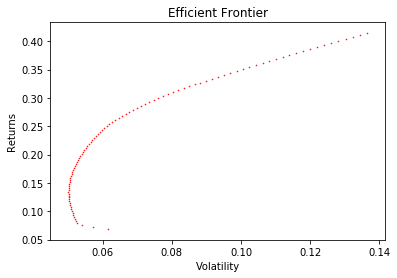

In [155]:
l = ["Smoke", "Fin", "Games", "Coal"] #let's just pick 4 assets to make the programme run faster, but I tried 
                                        # with all the assets and it works fine 

ef_data = erk.ef_multi(100,er[l],cov.loc[l,l], plot=True)

In [156]:
ef_data

,Returns,Volatility,Smoke,Fin,Games,Coal
0,0.068212,0.061423,6.241704e-12,0.000000e+00,1.000000e+00,1.908196e-17
1,0.071711,0.057113,8.833594e-02,0.000000e+00,9.116641e-01,0.000000e+00
2,0.075211,0.054115,1.766719e-01,0.000000e+00,8.233281e-01,1.110223e-16
3,0.078711,0.052652,2.650078e-01,0.000000e+00,7.349922e-01,1.665335e-16
4,0.082211,0.052312,2.825824e-01,2.045826e-04,7.092133e-01,7.999785e-03
...,...,...,...,...,...,...
95,0.400690,0.128194,1.387779e-16,7.317200e-02,0.000000e+00,9.268280e-01
96,0.404190,0.130264,5.551115e-17,5.487900e-02,5.551115e-17,9.451210e-01
97,0.407689,0.132344,0.000000e+00,3.658600e-02,0.000000e+00,9.634140e-01
98,0.411189,0.134434,0.000000e+00,1.829300e-02,0.000000e+00,9.817070e-01


Of course, the weights in each row should add up to 1 (they do).